In [2]:
# Importing Required Libraries

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D, Flatten
from tensorflow.keras import Model

## Dataset

X_train shape =  (50000, 32, 32, 3)  X_test shape =  (10000, 32, 32, 3)


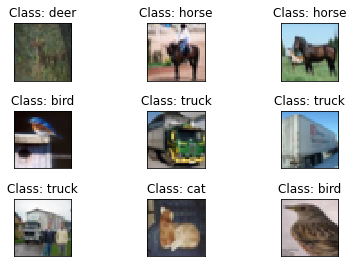

In [9]:
# Using Keras to load the dataset

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
print("X_train shape = ",X_train.shape," X_test shape = ",X_test.shape)

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse",
            "ship","truck"]

fig = plt.figure()
i = 10
while (i < 19):
  plt.subplot(3,3,i-9)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  title = "Class: "+class_names[int(y_train[i])]
  plt.title(title)
  plt.xticks([])
  plt.yticks([])
  i = i+1

## Model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   1728        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 32, 32, 64)   256         conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 128)  73728       batch_normalization_5[0][0]      
____________________________________________________________________________________________

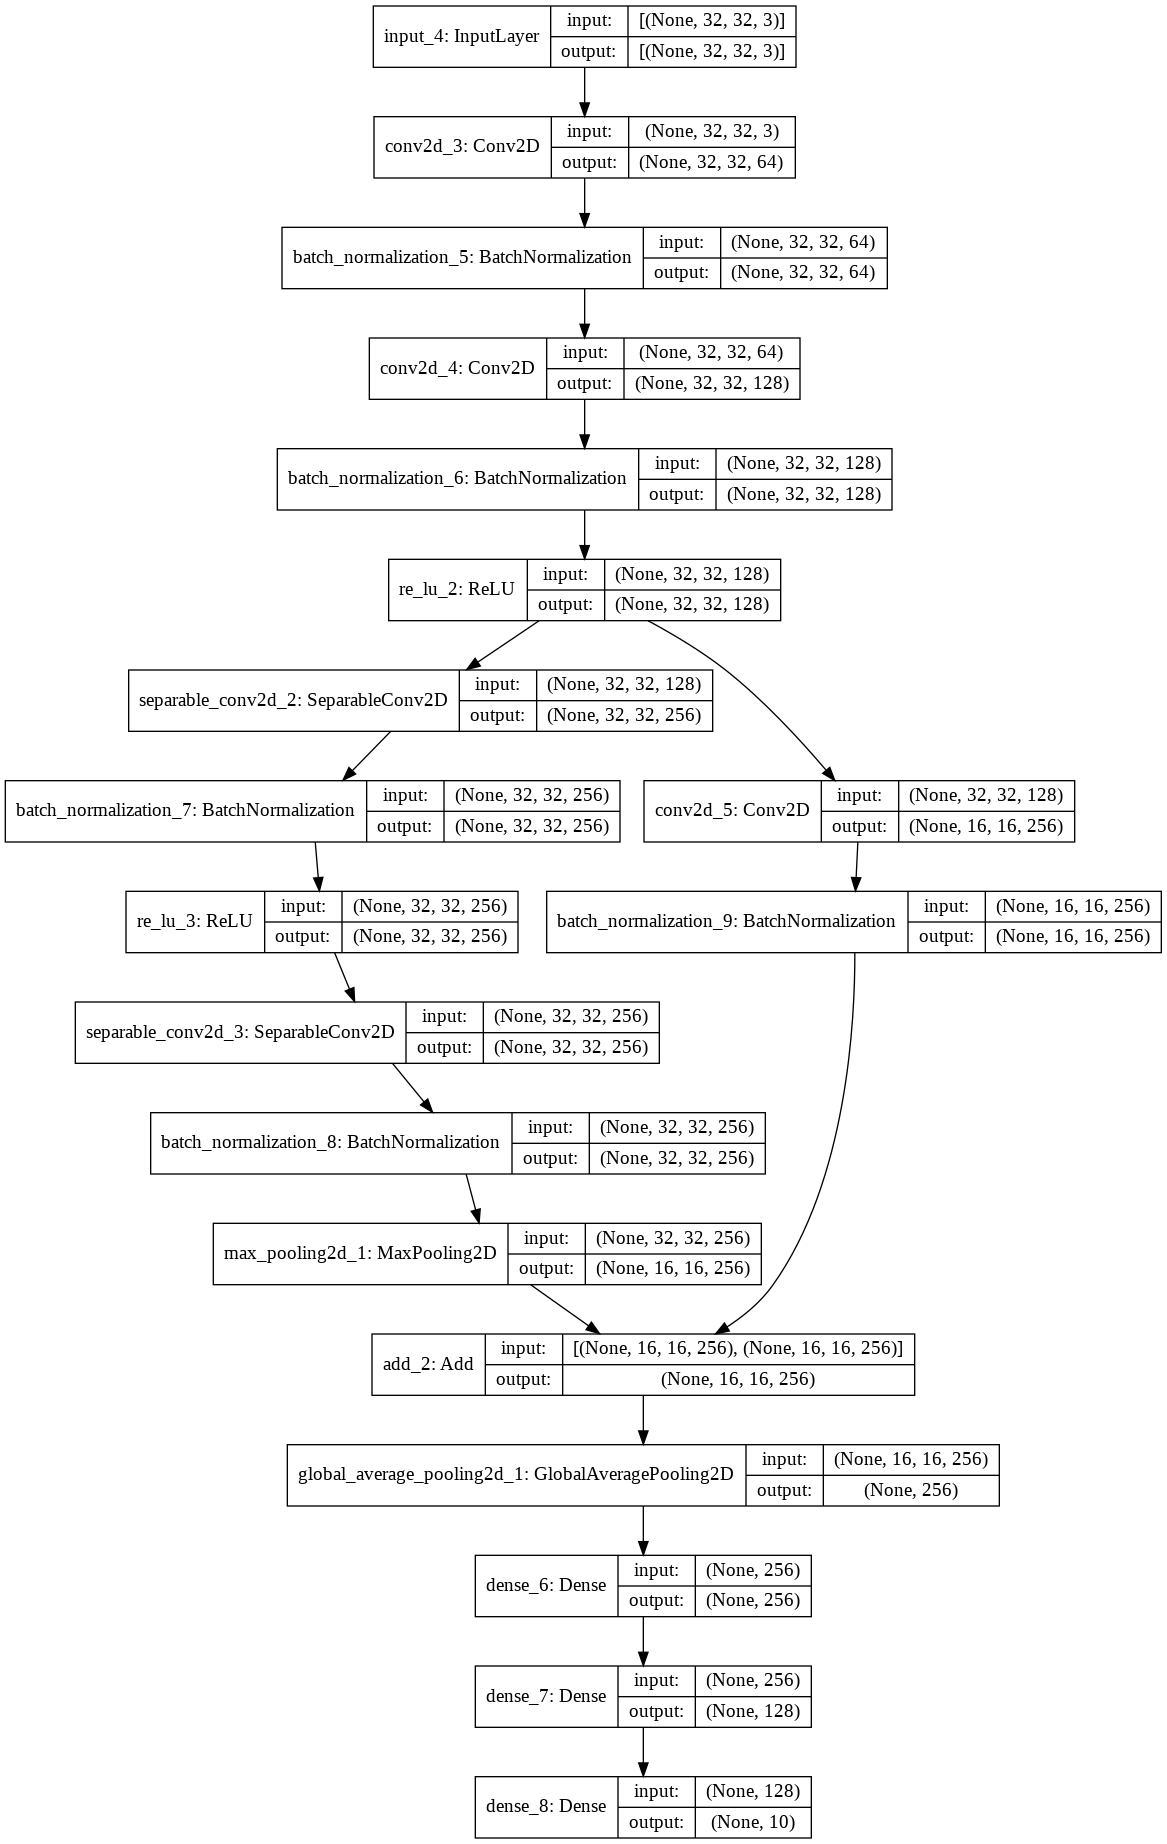

In [10]:
def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def my_block(x, filter):
    tensor = ReLU()(x)
    x = sep_bn(tensor, filters=filter, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=filter, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=filter, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = GlobalAvgPool2D()(x)
    return x
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

# Input
input = Input(shape=(32, 32,3))

# Blocks
my_model = conv_bn(input, filters=64, kernel_size=3, strides=1)
my_model = conv_bn(my_model, filters=128, kernel_size=3, strides=1)

# my_block
my_model = my_block(my_model, 256)

# Dense layers
my_model = Dense(units=256, activation='relu', 
                 kernel_initializer='he_uniform')(my_model)
my_model = Dense(units=128, activation='relu', 
                 kernel_initializer='he_uniform')(my_model)
# Output layer
output = Dense(units=10, activation='softmax')(my_model)

# Model
my_model = Model(inputs=input, outputs=output)

print(my_model.summary())

from tensorflow.keras.utils import plot_model
plot_model(my_model, show_shapes=True)


In [11]:
# Scale the pixel intensities down to the [0,1] range by dividing them by 255.0 
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
# Compiling the model
opt = keras.optimizers.Adam(learning_rate=0.01)
my_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Training and evaluating the model
history = my_model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

# plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()


313/313 [==============================] - 2s 7ms/step - loss: 1.3960 - accuracy: 0.7139
Loss     :  1.396047830581665
accuracy :  0.7139000296592712
-----------------------------------------------------------------------
0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
-----------------------------------------------------------------------
[[718   9  90  15  18  49   7  15  32  47]
 [ 17 851  14   3   2  16   4   3   6  84]
 [ 24   0 697  21  54 155  34  10   0   5]
 [ 10   4  72 324  50 476  25  22   1  16]
 [  5   1  73  16 690 168  15  29   2   1]
 [  1   2  17  37  19 911   2   6   0   5]
 [  5   1  68  36  47 134 700   6   1   2]
 [  5   1  30  18  56 255   4 629   0   2]
 [ 74  17  57  10  10  17   7   7 760  41]
 [ 14  63  10   9   4  22   1   6  12 859]]
-----------------------------------------------------------------------


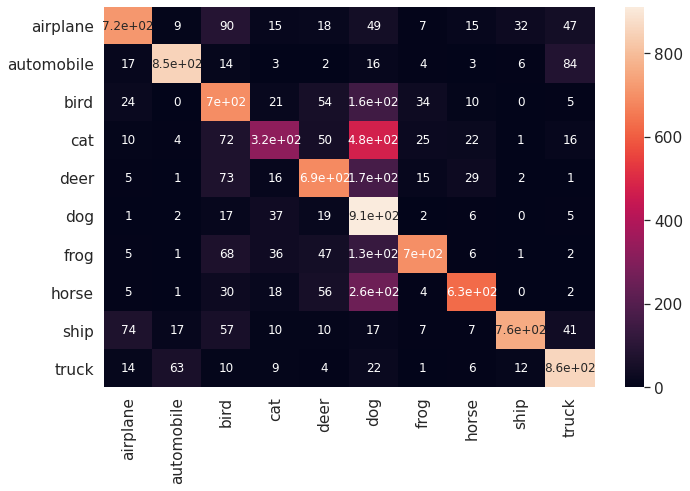

-----------------------------------------------------------------------


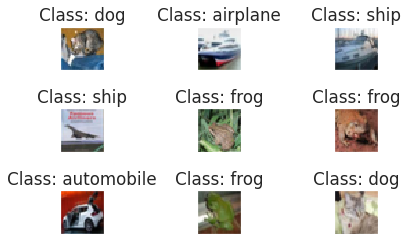

In [ ]:
# Evaluate the model
model_evaluate = my_model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])
print("-----------------------------------------------------------------------")

# Confusion matrix result
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = my_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())

cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print("-----------------------------------------------------------------------")
print(cm)
print("-----------------------------------------------------------------------")

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd
df_cm = pd.DataFrame(cm, class_names, class_names)
plt.figure(figsize = (11,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}) # font size
plt.show()

print("-----------------------------------------------------------------------")
# Results
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_test[i], cmap='gray', interpolation='none')
  title = "Class: "+class_names[int(y_pred[i])]
  plt.title(title)
  plt.xticks([])
  plt.yticks([])